<a href="https://colab.research.google.com/github/yakuparas28/YuksekLisans/blob/main/VeriMadencili%C4%9Fi_%C4%B0leriKonular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# İstanbul için enlem ve boylam
LAT = 41.0082
LON = 28.9784

# API URL'si
URL = f"https://www.7timer.info/bin/api.pl?lon={LON}&lat={LAT}&product=civil&output=json"

# API'den veri al
response = requests.get(URL)
if response.status_code == 200:
    weather_data = response.json()
    print("Veri başarıyla alındı!")
else:
    print(f"API isteği başarısız! Durum kodu: {response.status_code}")

# Verileri işleme
data = []
if "dataseries" in weather_data:
    # Şu anki tarihi başlatma noktası olarak al
    start_date = datetime.now()

    for item in weather_data["dataseries"]:
        forecast_time = start_date + timedelta(hours=item["timepoint"])
        data.append({
            "forecast_time": forecast_time.strftime("%Y-%m-%d %H:%M:%S"),
            "temperature": item["temp2m"],
            "humidity": item["rh2m"],
            "weather": item["weather"],
            "precipitation_type": item["prec_type"],
            "precipitation_amount": item["prec_amount"],
            "wind_direction": item["wind10m"]["direction"],
            "wind_speed": item["wind10m"]["speed"]
        })

# Verileri bir DataFrame'e dönüştür ve CSV'ye kaydet
df = pd.DataFrame(data)
df.to_csv("istanbul.csv", index=False)
print("Veriler CSV dosyasına kaydedildi.")


Veri başarıyla alındı!
Veriler CSV dosyasına kaydedildi.


       temperature  precipitation_amount  wind_speed
count    64.000000             64.000000   64.000000
mean      5.171875              0.062500    2.468750
std       1.638376              0.302109    0.502967
min      -1.000000              0.000000    2.000000
25%       4.000000              0.000000    2.000000
50%       5.000000              0.000000    2.000000
75%       6.000000              0.000000    3.000000
max      10.000000              2.000000    3.000000


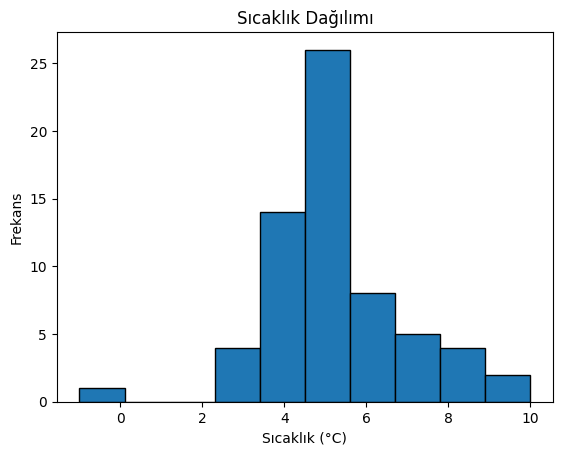

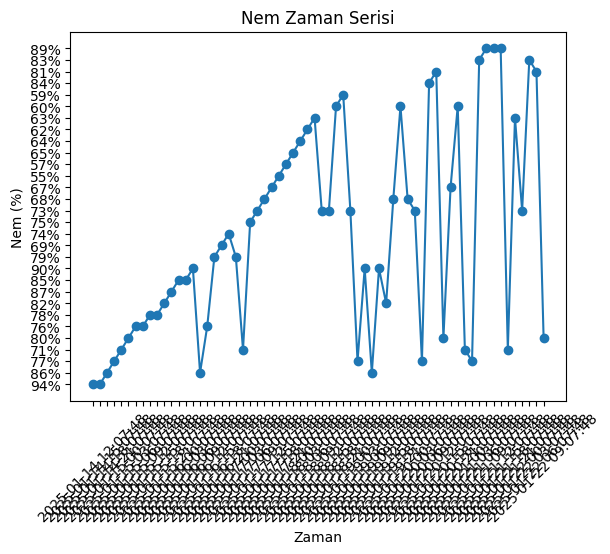

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Veriyi yükle
df = pd.read_csv("7timer_weather_data.csv")

# Temel istatistikler
print(df.describe())

# Sıcaklık dağılımı
plt.hist(df["temperature"], bins=10, edgecolor="k")
plt.title("Sıcaklık Dağılımı")
plt.xlabel("Sıcaklık (°C)")
plt.ylabel("Frekans")
plt.show()

# Nem zaman serisi
plt.plot(df["forecast_time"], df["humidity"], marker="o")
plt.title("Nem Zaman Serisi")
plt.xlabel("Zaman")
plt.ylabel("Nem (%)")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Zamanı datetime formatına çevir
df["forecast_time"] = pd.to_datetime(df["forecast_time"])

# Kategorik değişkenleri One-Hot Encoding ile dönüştür
encoder = OneHotEncoder(sparse_output=False)  # 'sparse' yerine 'sparse_output' kullanıldı
weather_encoded = encoder.fit_transform(df[["weather"]])

# Yeni DataFrame'e ekle
encoded_df = pd.DataFrame(weather_encoded, columns=encoder.get_feature_names_out(["weather"]))
df = pd.concat([df, encoded_df], axis=1)

# Girdi ve çıktı değişkenlerini ayır
X = df[["temperature", "humidity", "wind_speed"] + list(encoded_df.columns)]
y = df["temperature"].shift(-1).dropna()  # Gelecek sıcaklığı tahmin etmek
X = X.iloc[:-1, :]  # Hedef değişkenin satırlarına uygun hale getirme

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Veriyi yükle
df = pd.read_csv("7timer_weather_data.csv")

# Yüzde işaretini kaldır ve sayıya dönüştür
df["humidity"] = df["humidity"].str.replace('%', '').astype(float)

# Kategorik değişkenleri One-Hot Encoding ile dönüştür
encoder = OneHotEncoder(sparse_output=False)
weather_encoded = encoder.fit_transform(df[["weather"]])
encoded_df = pd.DataFrame(weather_encoded, columns=encoder.get_feature_names_out(["weather"]))
df = pd.concat([df, encoded_df], axis=1)

# Girdi ve çıktı değişkenlerini ayır
X = df[["temperature", "humidity", "wind_speed"] + list(encoded_df.columns)]
y = df["temperature"].shift(-1).dropna()  # Gelecek sıcaklığı tahmin etmek
X = X.iloc[:-1, :]  # Hedef değişkenin satırlarına uygun hale getirme

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli eğit
model = LinearRegression()
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Performans değerlendirme
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")



Mean Squared Error: 1.07
R2 Score: 0.43


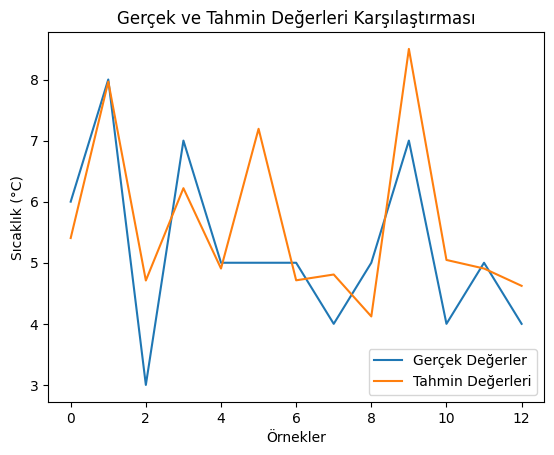

In [ ]:
plt.plot(y_test.values, label="Gerçek Değerler")
plt.plot(y_pred, label="Tahmin Değerleri")
plt.legend()
plt.title("Gerçek ve Tahmin Değerleri Karşılaştırması")
plt.xlabel("Örnekler")
plt.ylabel("Sıcaklık (°C)")
plt.show()


ADF Test Statistic: 0.1611676426779195
p-value: 0.9699975462828526
Veri durağan değil, fark alıyoruz...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3h will be used.
  self._init_dates(dates, freq)


Tahminler: 2025-01-22 12:07:48    0.178320
2025-01-22 15:07:48   -0.075242
2025-01-22 18:07:48    0.170062
2025-01-22 21:07:48   -0.067204
2025-01-23 00:07:48    0.162288
2025-01-23 03:07:48   -0.059684
2025-01-23 06:07:48    0.155015
2025-01-23 09:07:48   -0.052649
2025-01-23 12:07:48    0.148210
2025-01-23 15:07:48   -0.046068
Freq: 3h, Name: predicted_mean, dtype: float64


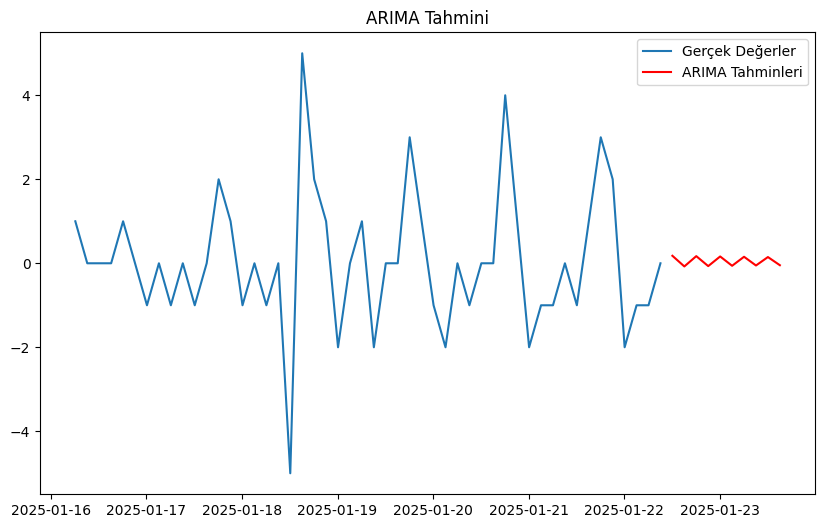

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Zaman serisi verisini hazırlama
df["forecast_time"] = pd.to_datetime(df["forecast_time"])
df.set_index("forecast_time", inplace=True)

# Sadece sıcaklık sütunu ile çalışalım
temperature_series = df["temperature"]

# Durağanlık testi (ADF testi)
adf_test = adfuller(temperature_series)
print(f"ADF Test Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    print("Veri durağan değil, fark alıyoruz...")
    temperature_series = temperature_series.diff().dropna()

# ARIMA modeli kurma (p=2, d=1, q=2) - Parametreler optimize edilebilir
model = ARIMA(temperature_series, order=(2, 1, 2))
fitted_model = model.fit()

# Tahmin yapma
forecast = fitted_model.forecast(steps=10)  # Gelecek 10 adımı tahmin et
print("Tahminler:", forecast)

# Tahminlerin görselleştirilmesi
plt.figure(figsize=(10, 6))
plt.plot(temperature_series[-50:], label="Gerçek Değerler")  # Son 50 değer
plt.plot(forecast, label="ARIMA Tahminleri", color='red')
plt.legend()
plt.title("ARIMA Tahmini")
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.2652
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2534
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2277 
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1998 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1718 
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1513 
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1142 
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1043 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0841 
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0559
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0383 
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0347 
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0288
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0352 
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0389 
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━

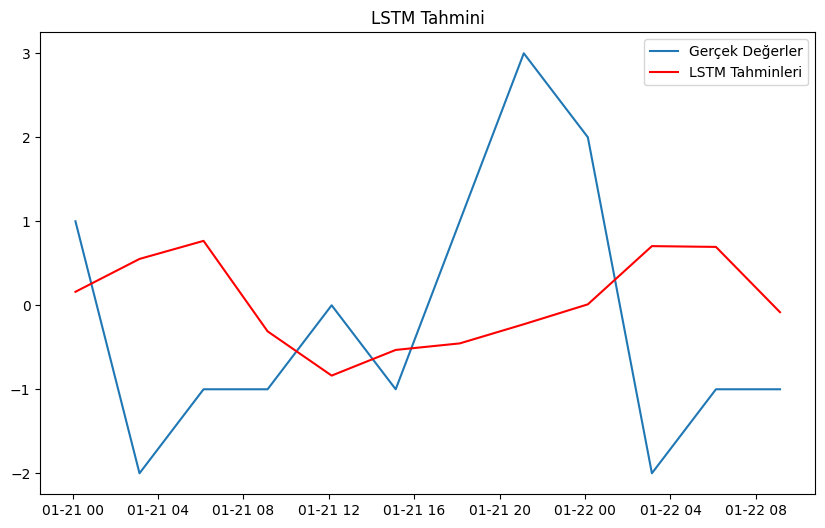

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Veriyi normalleştirme
scaler = MinMaxScaler(feature_range=(0, 1))
temperature_scaled = scaler.fit_transform(temperature_series.values.reshape(-1, 1))

# Zaman serisi formatına dönüştürme (X, y)
def create_dataset(dataset, look_back=3):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 3  # Göz önüne alınacak geçmiş veri
X, y = create_dataset(temperature_scaled, look_back)

# Veriyi eğitim ve test setine bölme
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Veriyi LSTM için yeniden şekillendirme
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM Modeli
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğitme
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Tahmin yapma
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Tahminleri eski değer aralığına dönüştürme
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Tahminlerin görselleştirilmesi
plt.figure(figsize=(10, 6))
plt.plot(temperature_series.index[-len(y_test[0]):], y_test[0], label="Gerçek Değerler")
plt.plot(temperature_series.index[-len(test_predict):], test_predict, label="LSTM Tahminleri", color='red')
plt.legend()
plt.title("LSTM Tahmini")
plt.show()
